In [1]:
import numpy as np
import numpy.random
from scipy.special import expit
from time import time

eps = 1e-15

def grad_finite_diff(function, w, eps=1e-8):
    return (np.apply_along_axis(function, 1, w + np.diag(np.full(len(w), eps))) - function(w)) / eps


class BaseSmoothOracle:
    def func(self, w):
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryLogistic(BaseSmoothOracle):
    def __init__(self, l2_coef=0):
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        log_loss = -np.log(np.clip(expit(y * X.dot(w)), eps, 1 - eps))
        return log_loss.mean() + self.l2_coef / 2 * np.linalg.norm(w) ** 2

    def grad(self, X, y, w):
        grad_log_loss = -X.T.dot(np.clip(expit(-y * X.dot(w)), eps, 1 - eps) * y) / X.shape[0]
        return grad_log_loss + self.l2_coef * w


class GDClassifier:
    def __init__(self, loss_function='binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-5, max_iter=1000, **kwargs):
        if loss_function != 'binary_logistic':
            raise TypeError(f'{loss_function} is not supported')
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.oracle = BinaryLogistic(**kwargs)

    def fit(self, X, y, w_0=None, trace=True, dataframe=None):
        if w_0 is None:
            w_0 = np.random.uniform(-1 / X.shape[1], 1 / X.shape[1], X.shape[1])
        self.w = w_0
        time_lst, func_lst = [], []
        accuracy_lst = []
        n_iter = 0
        while n_iter < self.max_iter + 1:
            timer = time()
            if n_iter != 0:
                grad = self.get_gradient(X, y)
                self.w -= (self.step_alpha / n_iter ** self.step_beta) * grad
            time_lst.append(time() - timer)
            func_lst.append(self.get_objective(X, y))
            if dataframe is not None:
                accuracy = (self.predict(dataframe[0]) == dataframe[1]).mean()
                accuracy_lst.append(accuracy)
            if n_iter > 0 and abs(func_lst[-1] - func_lst[-2]) < self.tolerance:
                break
            n_iter += 1
        if trace:
            history = {'time': time_lst, 'func': func_lst}
            if dataframe is not None:
                history['accuracy'] = accuracy_lst
            return history

    def predict(self, X):
        return np.where(X.dot(self.w) >= 0, 1, -1)

    def predict_proba(self, X):
        proba = expit(X.dot(self.w))
        return np.c_(1 - proba, proba)

    def get_objective(self, X, y):
        return self.oracle.func(X, y, self.w)

    def get_gradient(self, X, y):
        return self.oracle.grad(X, y, self.w)

    def get_weights(self):
        return self.w


class SGDClassifier(GDClassifier):
    def __init__(self, loss_function='binary_logistic', batch_size=512, step_alpha=0.1, step_beta=0, tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs):
        super().__init__(loss_function, step_alpha, step_beta, tolerance, max_iter, **kwargs)
        self.random_seed = random_seed
        self.batch_size = batch_size

    def fit(self, X, y, w_0=None, trace=True, log_freq=1, dataframe=None):
        np.random.seed(self.random_seed)
        if w_0 is None:
            w_0 = np.random.uniform(-1 / X.shape[1], 1 / X.shape[1], X.shape[1])
        self.w = w_0
        time_lst, func_lst, weights_diff_lst = [], [], []
        accuracy_lst = []
        proceed_batches_count = X.shape[0] // self.batch_size
        batch_threshold = log_freq * X.shape[0] / self.batch_size
        func_lst.append(self.get_objective(X, y))
        time_lst.append(0)
        weights_diff_lst.append(0.0)
        w_prev = self.w.copy()
        batch_count = [0, 0]
        if dataframe is not None:
            accuracy = (self.predict(dataframe[0]) == dataframe[1]).mean()
            accuracy_lst.append(accuracy)

        tolerance_check = False
        n_iter = 1
        timer = time()
        timer_check = True
        while n_iter < self.max_iter + 1:
            X_ind_shuffled = (np.random.default_rng(self.random_seed).permutation(X.shape[0]))
            epoch_ind = X_ind_shuffled[:X.shape[0] - X.shape[0] % self.batch_size]
            batch_ind = np.split(epoch_ind, proceed_batches_count)
            for i, ind in enumerate(batch_ind):
                batch_count[-1] += 1
                grad = self.get_gradient(X[ind], y[ind])
                self.w -= (self.step_alpha / n_iter ** self.step_beta) * grad
                if batch_count[-1] - batch_count[-2] > batch_threshold:
                    timer_check = False
                    func_lst.append(self.get_objective(X, y))
                    time_lst.append(time() - timer)
                    weights_diff_lst.append(np.inner(w_prev - self.w, w_prev - self.w))
                    w_prev = self.w.copy()
                    if dataframe is not None:
                        accuracy = (self.predict(dataframe[0]) == dataframe[1]).mean()
                        accuracy_lst.append(accuracy)
                    if abs(func_lst[-1] - func_lst[-2]) < self.tolerance:
                        tolerance_check = True
                        break
                    if n_iter < self.max_iter or i < proceed_batches_count - 1:
                        batch_count.append(batch_count[-1])
                        timer = time()
                        timer_check = True
            if tolerance_check:  # exit from while
                break
            n_iter += 1

        if timer_check:
            func_lst.append(self.get_objective(X, y))
            time_lst.append(time() - timer)
            weights_diff_lst.append(np.inner(w_prev - self.w, w_prev - self.w))
            if dataframe is not None:
                accuracy = (self.predict(dataframe[0]) == dataframe[1]).mean()
                accuracy_lst.append(accuracy)

        if trace:
            epoch_lst = list(np.array(batch_count) * self.batch_size / X.shape[0])
            history = {'time': time_lst, 'func': func_lst, 'epoch_num': epoch_lst, 'weights_diff': weights_diff_lst}
            if dataframe is not None:
                history['accuracy'] = accuracy_lst
            return history



### Подготовка

In [2]:
import numpy as np
import scipy as sc
import pandas as pd
from scipy.special import expit as sgm

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib_inline

In [4]:
import csv

In [5]:
import regex

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
data_train = pd.read_csv(r'C:\Users\kadch\MyPrograms\prak-fall-2022\data_toxic\toxic_train.csv')
data_test = pd.read_csv(r'C:\Users\kadch\MyPrograms\prak-fall-2022\data_toxic\toxic_test.csv')

In [8]:
data_train

,Unnamed: 0,comment_text,is_toxic
0,0,Explanation\nWhy the edits made under my usern...,False
1,1,D'aww! He matches this background colour I'm s...,False
2,2,"Hey man, I'm really not trying to edit war. It...",False
3,3,"""\nMore\nI can't make any real suggestions on ...",False
4,4,"You, sir, are my hero. Any chance you remember...",False
...,...,...,...
52056,159494,"""\n\n our previous conversation \n\nyou fuckin...",True
52057,159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,True
52058,159541,Your absurd edits \n\nYour absurd edits on gre...,True
52059,159546,"""\n\nHey listen don't you ever!!!! Delete my e...",True


### Эксперимент №1 - Предобработка

In [9]:
data_train['comment_text'] = data_train['comment_text'].str.lower()

In [10]:
data_test['comment_text'] = data_test['comment_text'].str.lower()

In [11]:
def change(text):
    res = []
    for line in text:
        res.append(regex.sub('[^0-9a-zа-яё ]', ' ', line))
    return res

In [12]:
data_train['comment_text'] = change(data_train['comment_text'])

In [13]:
data_test['comment_text'] = change(data_test['comment_text'])

In [14]:
def binarization(target):
    res = []
    for value in target:
        res.append(1 if value is True else -1)
    return res

In [15]:
data_train['is_toxic'] = binarization(data_train['is_toxic'])
data_test['is_toxic'] = binarization(data_test['is_toxic'])

In [16]:
data_train = data_train.drop(['Unnamed: 0'], axis = 1)
data_test = data_test.drop(['Unnamed: 0'], axis = 1)

### Эксперимент №2 - Преобразование в разреженную матрицу

In [17]:
vectorized = CountVectorizer(min_df=5)
X_train = vectorized.fit_transform(data_train['comment_text'])
X_test = vectorized.transform(data_test['comment_text'])
y_train = data_train['is_toxic']
y_test = data_test['is_toxic']

In [18]:
X_train.shape, X_test.shape

((52061, 18252), (20676, 18252))

### Эксперимент №3 - Численный/аналитический подсчёт градиента

In [19]:
def grad_finite_diff(f, w, eps0=1e-8):
    grad = np.zeros(w.shape[0])
    for i in range(w.shape[0]):
        e_i = np.zeros(w.shape)
        e_i[i] = 1
        grad[i] = (f(w + eps0 * e_i) - f(w)) / eps0
    return grad

In [20]:
train_size = int(0.8 * X_train.shape[0])
X_valid, y_valid = X_train[train_size:], y_train[train_size:]
X_train, y_train = X_train[:train_size], y_train[:train_size]

In [21]:
model = BinaryLogistic()
def f(w):
    return model.func(X_train, y_train, w)

w = np.random.uniform(-1 / X_train.shape[1], 1 / X_train.shape[1], X_train.shape[1])
timer = time()
a = grad_finite_diff(f, w).reshape(-1)
time_numeric = time() - timer
timer = time()
b = model.grad(X_train, y_train, w)
time_analyt = time() - timer
print('Gradient numerically - ', np.linalg.norm(a), '\n time = ', time_numeric, '\n')
print('Gradient analytically - ', np.linalg.norm(b), '\n time = ', time_analyt, '\n')
print('Norm of difference - ', np.linalg.norm(a - b))

Gradient numerically -  2.156374071540617 
 time =  516.7719120979309 

Gradient analytically -  2.1563740330135976 
 time =  0.02715444564819336 

Norm of difference -  8.940442277692833e-07


### Эксперимент №4 - Поведение GD в зависимости от step_alpha, step_beta, нач. приближения

In [22]:
alphas = [0.001, 0.01, 0.1, 1, 2]
betaes = [0, 0.1, 1, 2]

In [23]:
parametres_dict = {}
for beta in betaes:
    for alpha in alphas:
        model = GDClassifier(step_alpha=alpha, step_beta=beta)
        parametres_dict[(alpha, beta)] = model.fit(X_train, y_train, dataframe=(X_valid, y_valid))
np.save('alphas-betaes_GD.npy', parametres_dict)

C:\Users\kadch\AppData\Local\Temp\ipykernel_7092\3709817430.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


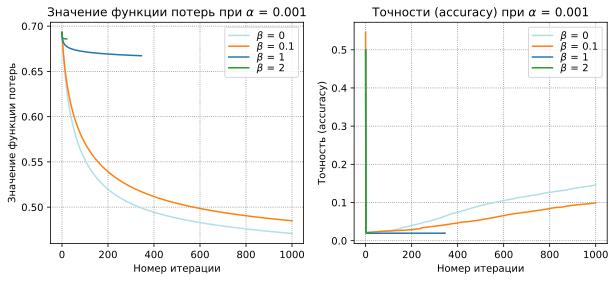

C:\Users\kadch\AppData\Local\Temp\ipykernel_7092\3709817430.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


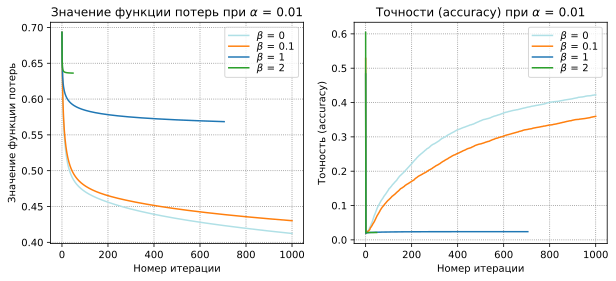

C:\Users\kadch\AppData\Local\Temp\ipykernel_7092\3709817430.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


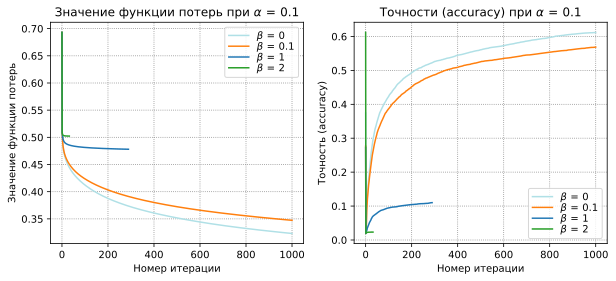

C:\Users\kadch\AppData\Local\Temp\ipykernel_7092\3709817430.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


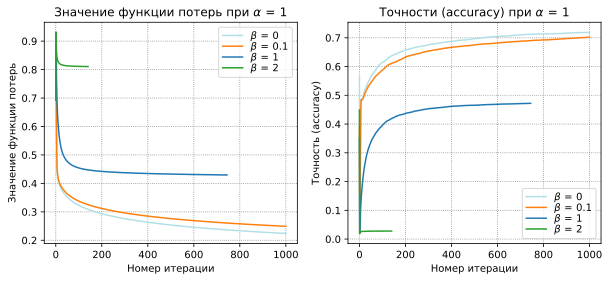

C:\Users\kadch\AppData\Local\Temp\ipykernel_7092\3709817430.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


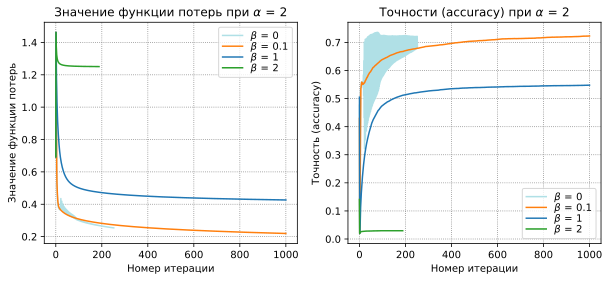

In [32]:
for alpha in alphas:
    fig = plt.figure(figsize=(10, 4))
    plt.grid()
    plt.subplot(1,2,1)
    plt.title(f'Значение функции потерь при $\\alpha\,=\,${alpha}')
    for beta in betaes:
        y = parametres_dict[alpha, beta]['func']
        x = np.arange(len(y))
        plt.plot(x, y, label=f'$\\beta\,=\,${beta}')
        plt.xlabel('Номер итерации')
        plt.ylabel('Значение функции потерь')
    plt.legend(loc='best')

    plt.subplot(1,2,2)
    plt.title(f'Точности (accuracy) при $\\alpha\,=\,${alpha}')
    for beta in betaes:
        y = parametres_dict[alpha, beta]['accuracy']
        x = np.arange(len(y))
        plt.plot(x, y, label=f'$\\beta\,=\,${beta}')
        plt.xlabel('Номер итерации')
        plt.ylabel('Точность (accuracy)')
    plt.legend(loc='best')

    plt.show()
    matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
    fig.savefig(f'exp4-(alpha={alpha}).pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

In [25]:
leng = X_train.shape[1]
w_0_lst = [np.zeros(leng), np.random.uniform(-1 / leng, 1 / leng, leng), np.random.uniform(-1, 1, leng), np.ones(leng)]
w_0_names = ['$w_{0_i}\,=\,0$', '$w_{0_i}\,\in\,[-\\frac{1}{d},\\frac{1}{d}]$', '$w_{0_i}\,\in\,[-1,1]$', '$w_{0_i}\,=\,1$']

In [26]:
w_0_dict = {}
for w_0, name in zip(w_0_lst, w_0_names):
    w_0_dict[name] = GDClassifier().fit(X_train, y_train, w_0=w_0, dataframe=(X_valid, y_valid))
np.save('w_0_gd.npy', w_0_dict)

C:\Users\kadch\AppData\Local\Temp\ipykernel_7092\2706023730.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


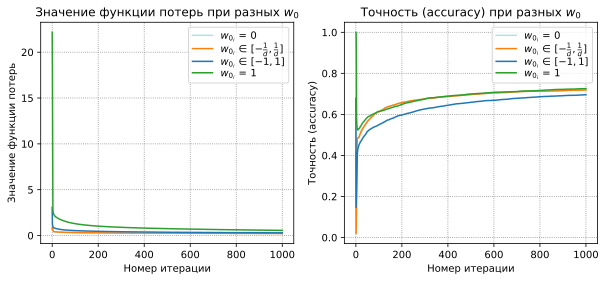

In [31]:
fig = plt.figure(figsize=(10, 4))
plt.grid()
plt.subplot(1,2,1)
plt.title(f'Значение функции потерь при разных $w_0$')
for name in w_0_names:
    y = w_0_dict[name]['func']
    x = np.arange(len(y))
    plt.plot(x, y, label=name)
    plt.xlabel('Номер итерации')
    plt.ylabel('Значение функции потерь')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title(f'Точность (accuracy) при разных $w_0$')
for name in w_0_names:
    y = w_0_dict[name]['accuracy']
    x = np.arange(len(y))
    plt.plot(x, y, label=name)
    plt.xlabel('Номер итерации')
    plt.ylabel('Точность (accuracy)')
plt.legend(loc='best')

plt.show()
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
fig.savefig(f'exp4-w_0).pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

### Эксперимент №5 - Поведение SGD в зависимости от step_alpha, step_beta, нач. приближения и batch_size

In [28]:
alphas = [0.001, 0.01, 0.1, 1, 2]
betaes = [0, 0.1, 1, 2]

In [ ]:
parametres2_dict = {}
for beta in betaes:
    for alpha in alphas:
        model = SGDClassifier(step_alpha=alpha, step_beta=beta)
        parametres2_dict[(alpha, beta)] = model.fit(X_train, y_train, dataframe=(X_valid, y_valid))
np.save('alphas-betaes_SGD.npy', parametres2_dict)

C:\Users\kadch\AppData\Local\Temp\ipykernel_6964\3866220446.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


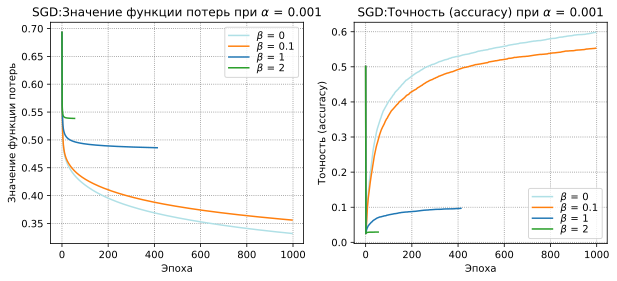

C:\Users\kadch\AppData\Local\Temp\ipykernel_6964\3866220446.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


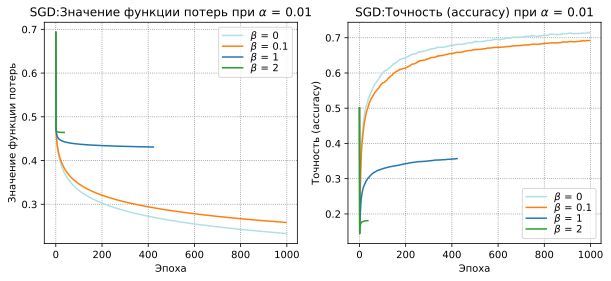

C:\Users\kadch\AppData\Local\Temp\ipykernel_6964\3866220446.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


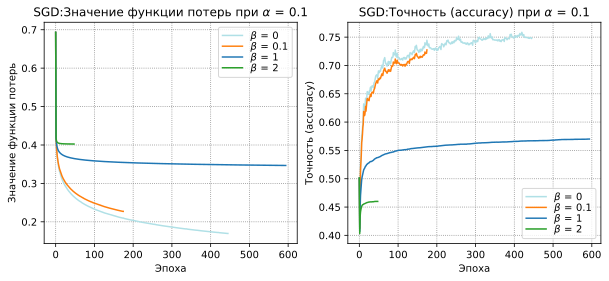

C:\Users\kadch\AppData\Local\Temp\ipykernel_6964\3866220446.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


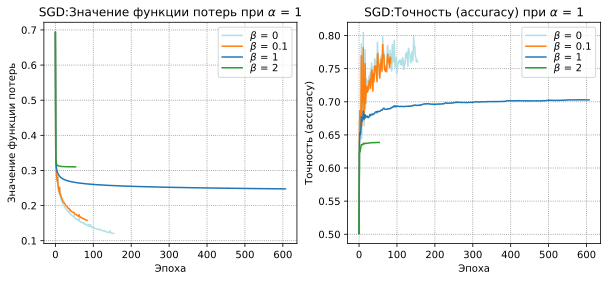

C:\Users\kadch\AppData\Local\Temp\ipykernel_6964\3866220446.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


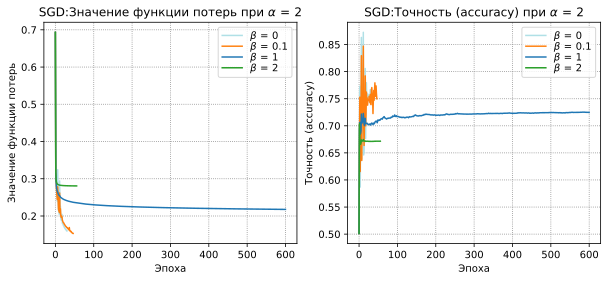

In [ ]:
for alpha in alphas:
    fig = plt.figure(figsize=(10, 4))
    plt.grid()
    plt.subplot(1,2,1)
    plt.title(f'SGD:Значение функции потерь при $\\alpha\,=\,${alpha}')
    for beta in betaes:
        y = parametres2_dict[alpha, beta]['func']
        x = parametres2_dict[alpha, beta]['epoch_num']
        plt.plot(x, y, label=f'$\\beta\,=\,${beta}')
        plt.xlabel('Эпоха')
        plt.ylabel('Значение функции потерь')
    plt.legend(loc='best')

    plt.subplot(1,2,2)
    plt.title(f'SGD:Точность (accuracy) при $\\alpha\,=\,${alpha}')
    for beta in betaes:
        y = parametres2_dict[alpha, beta]['accuracy']
        x = parametres2_dict[alpha, beta]['epoch_num']
        plt.plot(x, y, label=f'$\\beta\,=\,${beta}')
        plt.xlabel('Эпоха')
        plt.ylabel('Точность (accuracy)')
    plt.legend(loc='best')

    plt.show()
    matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
    fig.savefig(f'exp5-(alpha={alpha}).pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

In [ ]:
leng = X_train.shape[1]
w_0_lst = [np.zeros(leng), np.random.uniform(-1 / leng, 1 / leng, leng), np.random.uniform(-1, 1, leng), np.ones(leng)]
w_0_names = ['$w_{0_i}\,=\,0$', '$w_{0_i}\,\in\,[-\\frac{1}{d},\\frac{1}{d}]$', '$w_{0_i}\,\in\,[-1,1]$', '$w_{0_i}\,=\,1$']

In [ ]:
w_0_dict2 = {}
for w_0, name in zip(w_0_lst, w_0_names):
    w_0_dict2[name] = SGDClassifier().fit(X_train, y_train, w_0=w_0, dataframe=(X_valid, y_valid))
np.save('w_0_sgd.npy', w_0_dict2)

C:\Users\kadch\AppData\Local\Temp\ipykernel_6964\30793364.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


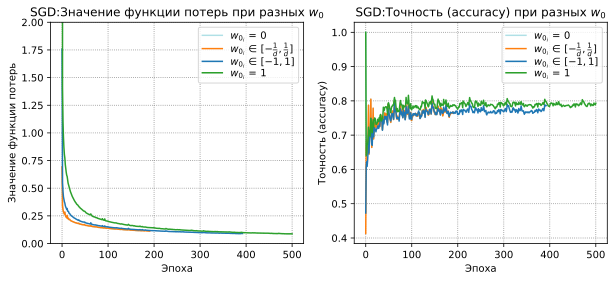

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.grid()
plt.subplot(1,2,1)
plt.title(f'SGD:Значение функции потерь при разных $w_0$')
for name in w_0_names:
    y = w_0_dict2[name]['func']
    x = w_0_dict2[name]['epoch_num']
    plt.plot(x, y, label=name)
    plt.xlabel('Эпоха')
    plt.ylabel('Значение функции потерь')
    plt.ylim(0, 2)
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title(f'SGD:Точность (accuracy) при разных $w_0$')
for name in w_0_names:
    y = w_0_dict2[name]['accuracy']
    x = w_0_dict2[name]['epoch_num']
    plt.plot(x, y, label=name)
    plt.xlabel('Эпоха')
    plt.ylabel('Точность (accuracy)')
plt.legend(loc='best')

plt.show()
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
fig.savefig(f'exp5-w_0).pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

In [ ]:
batch_sizes = [8, 64, 512, 4096]
batch_dict = {}
for batch in batch_sizes:
    model = SGDClassifier(batch_size = batch)
    batch_dict[batch] = model.fit(X_train, y_train, dataframe=(X_valid, y_valid))
np.save('exp5-batch_size.npy', batch_dict)

C:\Users\kadch\AppData\Local\Temp\ipykernel_6964\2171830264.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


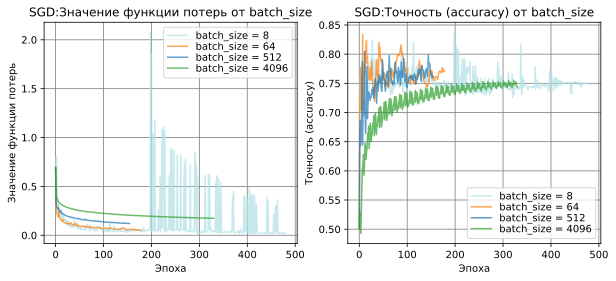

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.grid()
plt.subplot(1,2,1)
plt.title(f'SGD:Значение функции потерь от batch_size')
for batch in batch_sizes:
    y = batch_dict[batch]['func']
    x = batch_dict[batch]['epoch_num']
    plt.plot(x, y, label=f'batch_size = {batch}', alpha=0.7)
    plt.xlabel('Эпоха')
    plt.ylabel('Значение функции потерь')
    #plt.ylim(0, 2)
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title(f'SGD:Точность (accuracy) от batch_size')
for batch in batch_sizes:
    y = batch_dict[batch]['accuracy']
    x = batch_dict[batch]['epoch_num']
    plt.plot(x, y, label=f'batch_size = {batch}', alpha=0.7)
    plt.xlabel('Эпоха')
    plt.ylabel('Точность (accuracy)')
plt.legend(loc='best')

plt.show()
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
fig.savefig(f'exp5-batch_size.pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

### Эксперимент №6 - Сравнение GD и SGD между собой

In [33]:
dict_optim = {}
model1 = GDClassifier()
dict_optim['$GD$'] = model1.fit(X_train, y_train, dataframe=(X_valid, y_valid))
model2 = SGDClassifier(batch_size = 64)
dict_optim['$SGD$'] = model2.fit(X_train, y_train, dataframe=(X_valid, y_valid))

In [34]:
np.save('exp6-optim.npy', dict_optim)

C:\Users\kadch\AppData\Local\Temp\ipykernel_7092\136546307.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


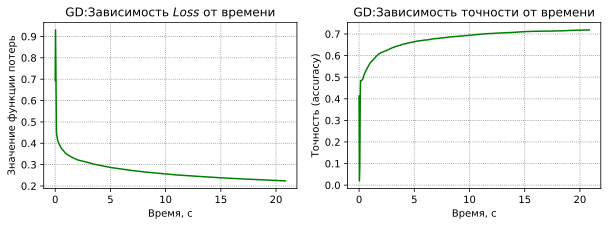

C:\Users\kadch\AppData\Local\Temp\ipykernel_7092\136546307.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


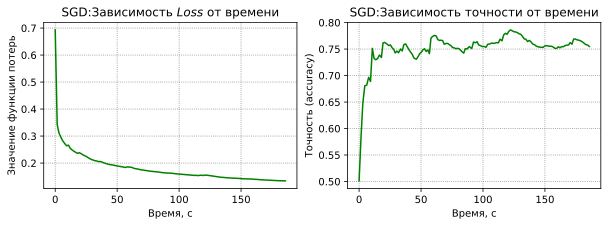

In [35]:
fig = plt.figure(figsize=(10, 3))
plt.grid()
plt.subplot(1,2,1)
plt.title(f'GD:Зависимость $Loss$ от времени')
y = dict_optim['$GD$']['func']
x = np.cumsum(dict_optim['$GD$']['time'])
plt.plot(x, y, color='g')
plt.xlabel('Время, с')
plt.ylabel('Значение функции потерь')

plt.subplot(1,2,2)
plt.title(f'GD:Зависимость точности от времени')
y = dict_optim['$GD$']['accuracy']
x = np.cumsum(dict_optim['$GD$']['time'])
plt.plot(x, y, color='g')
plt.xlabel('Время, с')
plt.ylabel('Точность (accuracy)')
plt.show()
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
fig.savefig('exp6-GD.pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')


fig = plt.figure(figsize=(10, 3))
plt.grid()
plt.subplot(1,2,1)
plt.title(f'SGD:Зависимость $Loss$ от времени')
y = dict_optim['$SGD$']['func']
x = np.cumsum(dict_optim['$SGD$']['time'])
plt.plot(x, y, color='g')
plt.xlabel('Время, с')
plt.ylabel('Значение функции потерь')

plt.subplot(1,2,2)
plt.title(f'SGD:Зависимость точности от времени')
y = dict_optim['$SGD$']['accuracy']
x = np.cumsum(dict_optim['$SGD$']['time'])
plt.plot(x, y, color='g')
plt.xlabel('Время, с')
plt.ylabel('Точность (accuracy)')

plt.show()
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
fig.savefig('exp6-SGD.pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

In [ ]:
accuracy_GD = np.array(dict_optim['$GD$']['accuracy'])[-1]
round(accuracy_GD, 4)

0.719

In [ ]:
best_accuracy = np.array(dict_optim['$SGD$']['accuracy'])[-1]
round(best_accuracy, 4)

0.7699

### Эксперимент №7 - Алгоритм лемматизации

In [39]:
train_size = int(0.8 * data_train.shape[0])
X_valid_words, y_valid_words = data_train['comment_text'][train_size:], data_train['is_toxic'][train_size:]
X_train_words, y_train_words = data_train['comment_text'][:train_size], data_train['is_toxic'][:train_size]
X_train.shape[0] == X_train_words.shape[0]

True

In [43]:
from nltk import WordNetLemmatizer

In [44]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kadch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kadch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.ADJ, 'V': wordnet.VERB,
        'N': wordnet.NOUN, 'R': wordnet.ADV
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.NOUN

In [46]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kadch\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [47]:
def simple_lemmatizer(sentence):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sentence.split()
    pos_taged = [
        (word, get_wordnet_pos(tag))
        for word, tag in nltk.pos_tag(tokenized_sent)
    ]
    return " ".join([
        lemmatizer.lemmatize(word, tag)
        for word, tag in pos_taged
    ])

In [ ]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [49]:
def complex_lemmatizer(dataframe):
    res = []
    for str in dataframe:
        res.append(simple_lemmatizer(str))
    return res

In [ ]:
X_train_words = complex_lemmatizer(X_train_words)
X_valid_words = complex_lemmatizer(X_valid_words)

In [ ]:
X_test_words = data_test['comment_text']
X_test_words = complex_lemmatizer(X_test_words)

In [50]:
from nltk.corpus import stopwords

In [ ]:
lemma_dict = {}
vectorized = CountVectorizer(min_df=5, stop_words='english')
X_train_new = vectorized.fit_transform(X_train_words)
X_valid_new = vectorized.transform(X_valid_words)
model = SGDClassifier(batch_size = 64)
lemma_dict['with_lemma'] = model.fit(X_train_new, y_train_words, dataframe=(X_valid_new, y_valid_words))

In [ ]:
model2 = GDClassifier()
lemma_dict['GD'] = model2.fit(X_train_new, y_train_words, dataframe=(X_valid_new, y_valid_words))

In [ ]:
print('Dimension before proccesing: ', X_train.shape)
print('Dimension after processing: ', X_train_new.shape)
print('\n')
print('Accuracy after processing(SGD): ', round(np.array(lemma_dict['with_lemma']['accuracy'])[-1], 4))
print('Accuracy after processing(GD): ', round(np.array(lemma_dict['GD']['accuracy'])[-1], 4))
print('\n')
print('Time after proccesing: ', np.cumsum(lemma_dict['with_lemma']['time'])[-1])

Dimension before proccesing:  (41648, 18252)
Dimension after processing:  (41648, 13005)


Accuracy after processing(SGD):  0.7655
Accuracy after processing(GD):  0.7009


Time after proccesing:  54.16467213630676


In [40]:
vectorized = CountVectorizer(min_df=5, stop_words='english')
X_train_new = vectorized.fit_transform(X_train_words)
X_valid_new = vectorized.transform(X_valid_words)
model = SGDClassifier(batch_size = 64)
lemma_dict['before_lemma'] = model.fit(X_train_new, y_train_words, dataframe=(X_valid_new, y_valid_words))
print('Time after proccesing: ', np.cumsum(lemma_dict['before

_lemma']['time'])[-1])

KeyboardInterrupt: 

Посчитаем accuracy на тестовой выборке после применения лемматизации

In [ ]:
X_TRAIN = data_train['comment_text']
X_TEST = data_test['comment_text']
X_TRAIN = complex_lemmatizer(X_TRAIN)
X_TEST = complex_lemmatizer(X_TEST)

In [ ]:
vectorized = CountVectorizer(min_df=5, stop_words='english')
X_TRAIN = vectorized.fit_transform(X_TRAIN)
X_TEST = vectorized.transform(X_TEST)

In [ ]:
main_dict = {}
model0 = SGDClassifier(batch_size = 64)
model0.fit(X_TRAIN, data_train['is_toxic'])

{'time': [0,
  1.8929481506347656,
  1.815584659576416,
  1.8328680992126465,
  2.1123788356781006,
  2.3665924072265625,
  2.431730270385742,
  2.222754716873169,
  2.4914233684539795,
  2.3993191719055176,
  2.3551509380340576,
  2.3229386806488037,
  2.604997158050537,
  2.5646798610687256,
  2.562757730484009,
  2.3660693168640137,
  2.4900388717651367,
  2.466456413269043,
  2.357884407043457,
  2.3015098571777344,
  2.3327627182006836,
  2.459714412689209,
  2.1871750354766846,
  2.3015010356903076,
  2.2878596782684326,
  2.3071014881134033,
  2.4123599529266357,
  2.4730067253112793,
  2.411848306655884,
  2.40010142326355,
  2.2284111976623535,
  2.3724474906921387,
  2.380958080291748,
  2.27126145362854,
  2.3456060886383057,
  2.4315004348754883,
  2.404210329055786,
  2.5681095123291016,
  2.4483399391174316,
  2.4682083129882812,
  2.5683488845825195,
  2.388530731201172,
  2.463634490966797,
  2.6006839275360107,
  2.697885036468506,
  2.607421636581421,
  2.478308677673

In [ ]:
print((model0.predict(X_TEST) == data_test['is_toxic']).mean())

0.8495356935577482


### Эксперимент №8 - зависимость от BagOfWords, Tfidf, min_df, max_df

In [51]:
train_size = int(0.8 * data_train.shape[0])
X_valid_words, y_valid_words = data_train['comment_text'][train_size:], data_train['is_toxic'][train_size:]
X_train_words, y_train_words = data_train['comment_text'][:train_size], data_train['is_toxic'][:train_size]

In [53]:
X_train_words = complex_lemmatizer(X_train_words)
X_valid_words = complex_lemmatizer(X_valid_words)

In [54]:
BOF_accuracy = []
Tfidf_accuracy = []
min_lst = [1, 3, 5, 10, 20, 40]
max_lst = [0.05, 0.2, 0.5, 0.8, 1.0]

In [55]:
y_TRAIN = y_train_words
y_TEST = y_valid_words

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
for min_df in min_lst:
    vectorizer = CountVectorizer(min_df=min_df)
    X_TRAIN = vectorizer.fit_transform(X_train_words)
    X_TEST = vectorizer.transform(X_valid_words)
    model = SGDClassifier()
    model.fit(X_TRAIN, y_TRAIN)
    BOF_accuracy.append((model.predict(X_TEST) == y_TEST).mean())
    
    tfidfer = TfidfVectorizer(min_df=min_df)
    X_TRAIN = tfidfer.fit_transform(X_train_words)
    X_TEST = tfidfer.transform(X_valid_words)
    model = SGDClassifier()
    model.fit(X_TRAIN, y_TRAIN)
    Tfidf_accuracy.append((model.predict(X_TEST) == y_TEST).mean())
 

KeyboardInterrupt: 

C:\Users\kadch\AppData\Local\Temp\ipykernel_6964\551566945.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


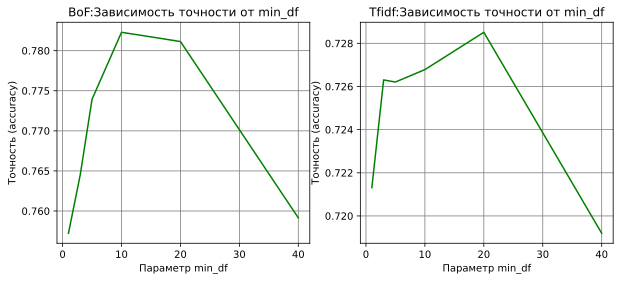

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.grid()
plt.subplot(1,2,1)
plt.title(f'BoF:Завиcимость точности от min_df')
y = BOF_accuracy
x = min_lst
plt.plot(x, y, color = 'green')
plt.xlabel('Параметр min_df')
plt.ylabel('Точность (accuracy)')

plt.subplot(1,2,2)
plt.title(f'Tfidf:Завиcимость точности от min_df')
y = Tfidf_accuracy
x = min_lst
plt.plot(x, y, color = 'green')
plt.xlabel('Параметр min_df')
plt.ylabel('Точность (accuracy)')

plt.show()
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
fig.savefig(f'exp8-min_df.pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

оптимальное значение min_df для BoF = 10, для Tfidf - 20 

In [ ]:
best_min_df_BOF = 10
best_min_df_Tfidf = 20

In [ ]:
BOF_accuracy_max = []
Tfidf_accuracy_max = []

In [ ]:
for max_df in max_lst:
    vectorizer = CountVectorizer(min_df=best_min_df_BOF, max_df=max_df)
    X_TRAIN = vectorizer.fit_transform(X_train_words)
    X_TEST = vectorizer.transform(X_valid_words)
    model = SGDClassifier()
    model.fit(X_TRAIN, y_TRAIN)
    BOF_accuracy_max.append((model.predict(X_TEST) == y_TEST).mean())
    
    tfidfer = TfidfVectorizer(min_df=best_min_df_Tfidf, max_df=max_df)
    X_TRAIN = tfidfer.fit_transform(X_train_words)
    X_TEST = tfidfer.transform(X_valid_words)
    model = SGDClassifier()
    model.fit(X_TRAIN, y_TRAIN)
    Tfidf_accuracy_max.append((model.predict(X_TEST) == y_TEST).mean())

C:\Users\kadch\AppData\Local\Temp\ipykernel_6964\352768992.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


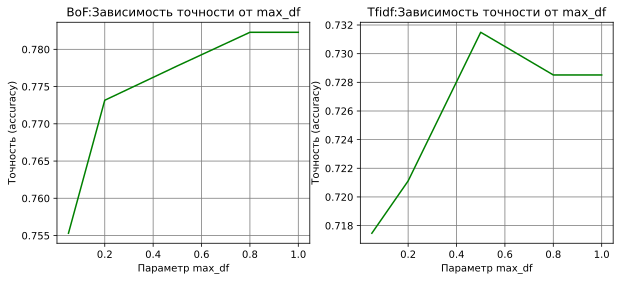

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.grid()
plt.subplot(1,2,1)
plt.title(f'BoF:Завиcимость точности от max_df')
y = BOF_accuracy_max
x = max_lst
plt.plot(x, y, color='green')
plt.xlabel('Параметр max_df')
plt.ylabel('Точность (accuracy)')

plt.subplot(1,2,2)
plt.title(f'Tfidf:Завиcимость точности от max_df')
y = Tfidf_accuracy_max
x = max_lst
plt.plot(x, y, color='green')
plt.xlabel('Параметр max_df')
plt.ylabel('Точность (accuracy)')

plt.show()
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
fig.savefig(f'exp8-max_df.pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

оптимальное значение max_df для BoF = 0.8, для Tfidf = 0.5
но BoF всё равно лучше

In [ ]:
best_max_df_BOF = 0.8
best_max_df_Tfidf = 0.5

### Эксперимент №9 - Выбор лучшего алгоритма для тестовой выборки

In [63]:
X_TRAIN = data_train['comment_text']
X_TEST = data_test['comment_text']
vectorized = CountVectorizer()
X_TRAIN = vectorized.fit_transform(X_TRAIN)
X_TEST = vectorized.transform(X_TEST)
model0 = SGDClassifier()
model0.fit(X_TRAIN, data_train['is_toxic'])
print('SGD before: ', (model0.predict(X_TEST) == data_test['is_toxic']).mean())

SGD before:  0.860466241052428


In [86]:
data_train_ = pd.read_csv(r'C:\Users\kadch\MyPrograms\prak-fall-2022\data_toxic\toxic_train.csv')
data_test_ = pd.read_csv(r'C:\Users\kadch\MyPrograms\prak-fall-2022\data_toxic\toxic_test.csv')
data_train_['is_toxic'] = binarization(data_train_['is_toxic'])
data_test_['is_toxic'] = binarization(data_test_['is_toxic'])

In [95]:
n = 0
i = 5870
errors = []
reals = []
predict = model0.predict(X_TEST)
real = data_test_['is_toxic']
while n < 6:
    if predict[i] != real[i] and len(data_test_['comment_text'][i]) < 100:
        errors.append(data_test_['comment_text'][i])
        reals.append(real[i])
        n += 1
    i += 1
errors, reals

(['Sockpuppet of Nomdeplume6000',
  "she is also a stipid boild dumpling who can't read or write",
  'HHAHAHA THE BROWN MAN LOVES SPERM  HAH',
  ':Niggaz b niggaz b niggaz; why be difficult about this?',
  'So DHS is not part of TMZ? If they were gay I bet no one would say anything.',
  '" \n\n :::::::Your comments to me on   "'],
 [-1, 1, -1, 1, -1, -1])

In [60]:
model0 = GDClassifier()
model0.fit(X_TRAIN, data_train['is_toxic'])
print('GD before: ', (model0.predict(X_TEST) == data_test['is_toxic']).mean())

GD before:  0.8520990520410138


In [61]:
X_TRAIN = data_train['comment_text']
X_TEST = data_test['comment_text']

In [ ]:
X_TRAIN = complex_lemmatizer(X_TRAIN)
X_TEST = complex_lemmatizer(X_TEST)

In [ ]:
vectorized = CountVectorizer(min_df=10, max_df=0.8, stop_words='english')
X_TRAIN = vectorized.fit_transform(X_TRAIN)
X_TEST = vectorized.transform(X_TEST)
model1 = SGDClassifier()
model1.fit(X_TRAIN, data_train['is_toxic'])
print('SGD after lemmatization: ', (model1.predict(X_TEST) == data_test['is_toxic']).mean())

SGD after lemmatization:  0.856210098665119


In [ ]:
model2 = GDClassifier()
model2.fit(X_TRAIN, data_train['is_toxic'])
print('GD after lemmatization: ', (model2.predict(X_TEST) == data_test['is_toxic']).mean())

GD after lemmatization:  0.8548558715418844


In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

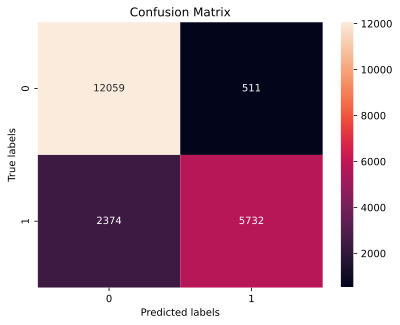

In [89]:
cm = confusion_matrix(predict, real)
fig = plt.figure()
ax=plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
fig.savefig('exp9-confusion_matrix9.pdf')